In [1]:
import torch 
import numpy as np

from ctr_pr_gd import *
from ctr_pr_gs import *
from utils import *
from propagator import *
from plotting import *

# torch.manual_seed(0)
# np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
def demo_phase_retrieval(device="cpu"):
    device = torch.device(device)

    # 1) z-grid + true bunch
    z = make_z_grid(N=2048, Lz=1e-3, device=device)
    rho_true = make_true_bunch(z)

    # 2) synthetic measured spectrum
    # I_meas, _ = forward_spectrum_fft(rho_true)
    
    ## ----- start: uncomment block if using Schroeder 
    gamma = 100.0
    k_grid, omega_grid = make_k_and_omega_grids(z, gamma)

    I_meas, F_omega_true = forward_spectrum_schroeder_1d(
        z=z,
        rho=rho_true,
        omega=omega_grid,
        gamma=gamma,
        normalize=True,   # same behavior as before
    )
    ## ----- end: uncomment block if using Schroeder 

    ## optional: add a bit of noise (Bi can play around w/ this)
    # noise_level = 0.01
    # I_meas = I_meas * (1 + noise_level * torch.randn_like(I_meas))

    # 3) support: we "know" bunch is within +-30 µm
    
    support = "tukey"
    half_width=100e-6 # we can play around w/ this
    # with control of plasma density, you can control bubble size and 
    # therefore, you have an upper limit the beam length 
    if support == "soft":
        support_mask = make_soft_support(z, half_width=half_width) # or make_hann_support or make_tukey_support
    elif support == "hann":
        support_mask = make_hann_support(z, half_width=half_width) # or make_hann_support or make_tukey_support
    elif support == "tukey":
        support_mask = make_tukey_support(z, half_width, alpha=0.5)  # try alpha = 0.3–0.7
    else:
        support_mask = make_support_mask(z, half_width=half_width)
    
    # 4) GS reconstruction
    
    # rho_gs_single = gerchberg_saxton_1d_torch(
    #     I_meas=I_meas,
    #     n_iters=500,
    #     support_mask=support_mask,
    #     device=device,
    # )
    
    
    sigma_z = compute_sigma_z(z, rho_true)
    z0_true, sigma_z_true = compute_mean_and_sigma_z(z, rho_true) # for synthetic data only
    
    rho_gs = gerchberg_saxton_multistart(
        I_meas=I_meas,
        n_iters=1000,
        support_mask=support_mask,
        n_restarts=50,
        # method = "schroeder",
        backend = "torch",
        device=device,
    )

    lr = 5e-3
    # 5) Gradient-descent reconstruction (PyTorch only)
    # rho_gd = gradient_descent(
    #     I_meas=I_meas,
    #     z = z,
    #     support_mask=support_mask,
    #     init_profile=rho_gs,
    #     n_steps=4000,
    #     lr=lr,
    #     lambda_smooth=1e-2,
    #     method = "fft",
    #     device=device,
    # )
    
    rho_init = make_smooth_init_from_support(z, support_mask)
    
    rho_gd, gd_loss = gradient_descent(
        I_meas=I_meas,
        z=z,
        support_mask=support_mask,
        init_profile=rho_gs,      # rho_gs for GS to GD refinement; otherwise rho_init
        n_steps=2000,
        lr=lr,
        gamma=100,
        method="fft",
        lambda_smooth=1e-2,
        z0_target=float(z0_true),         # physics prior on bunch center
        sigma_z_target=float(sigma_z_true),  # physics prior on bunch length
        # Max says there's no way to know the following from experiment
        lambda_com=0.0,                    # tune these weights (only for synthetic)
        lambda_sigma=0.0,                 # tune these weights (only for synthetic)
        device=device,
    )

    # 6) Compare profiles
    c_gs = corr_coef(rho_true, rho_gs)
    c_gd = corr_coef(rho_true, rho_gd)
    print(f"Correlation (true vs GS): {c_gs:.4f}")
    print(f"Correlation (true vs GD): {c_gd:.4f}")
    
    # 7) Spectra of reconstructions
    I_from_gs, _ = forward_spectrum_fft(rho_gs.to(device))
    I_from_gd, _ = forward_spectrum_fft(rho_gd.to(device))

    return z, rho_true, rho_gs, rho_gd, I_meas, I_from_gd, I_from_gs, sigma_z, gd_loss


if __name__ == "__main__":
    z, rho_true, rho_gs, rho_gd, I_meas, I_from_gd, I_from_gs, sigma_z, gd_loss = demo_phase_retrieval(device=device)

[GS-Torch-cuda] best spectral loss over 50 restarts: 3.790e-02
[GD] step    0, data=5.985e-02, smooth=1.629e-10, com=0.000e+00, sigma=0.000e+00, total=5.985e-02
[GD] step  500, data=2.763e+05, smooth=1.546e-10, com=0.000e+00, sigma=0.000e+00, total=2.763e+05
[GD] step 1000, data=3.164e+05, smooth=1.458e-10, com=0.000e+00, sigma=0.000e+00, total=3.164e+05
[GD] step 1500, data=3.706e+05, smooth=1.381e-10, com=0.000e+00, sigma=0.000e+00, total=3.706e+05
[GD] step 1999, data=3.738e+05, smooth=1.310e-10, com=0.000e+00, sigma=0.000e+00, total=3.738e+05
Correlation (true vs GS): 0.9676
Correlation (true vs GD): 0.9667


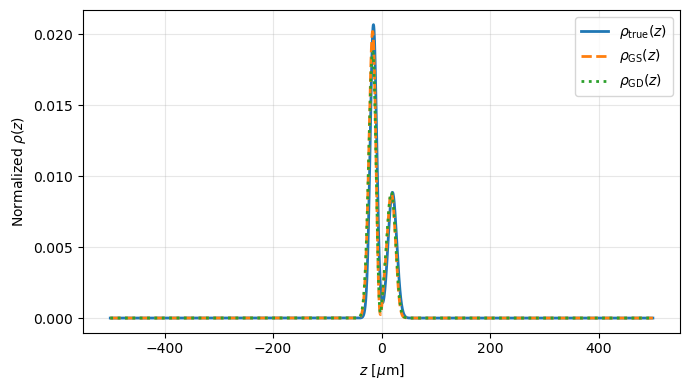

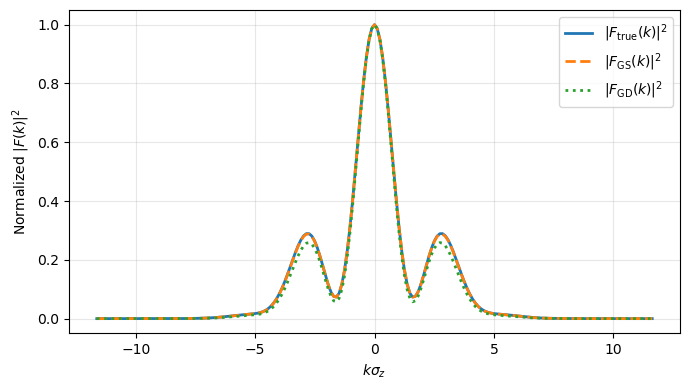

In [4]:
# 8) Plots
plot_bunch_profiles(z, rho_true, rho_gs, rho_gd)
plot_spectrum(I_meas, I_gd=I_from_gd, I_gs=I_from_gs, 
              z = z,
              sigma_z = sigma_z,
              title_suffix="(measured vs recon)",
              xlim_frac=0.1
             )

In [5]:
## main comparison 

def demo_compare_methods(
    device="cpu",
    method_gd="schroeder",
    gamma=100.0,
    support_type="tukey",
    half_width=100e-6,
):
    device = torch.device(device)

    # 1) grid + true bunch
    z = make_z_grid(N=1024, Lz=1e-3, device=device)
    rho_true = make_true_bunch(z)

    # 2) Schroeder forward for synthetic measured spectrum
    _, omega_grid = make_k_and_omega_grids(z, gamma)
    I_meas, _ = forward_spectrum_schroeder_1d(
        z=z, rho=rho_true, omega=omega_grid, gamma=gamma, normalize=True
    )

    # 3) choose support
    
    if support_type == "tukey":
        support_mask = make_tukey_support(z, half_width, alpha=0.5)
    elif support_type == "hann":
        support_mask = make_hann_support(z, half_width)
    elif support_type == "hard":
        support_mask = make_support_mask(z, half_width)   # original hard mask
    else:
        raise ValueError("support_type must be 'tukey', 'hann', or 'hard'")

        
    results = []

    # GS
    t0 = time.perf_counter()
    rho_gs = gerchberg_saxton_multistart(
        I_meas=I_meas,
        n_iters=800,
        support_mask=support_mask,
        n_restarts=50,
        device=device,
    )
    t1 = time.perf_counter()
    m_gs = evaluate_method("GS", rho_true, rho_gs, I_meas, z, gamma, forward="schroeder")
    m_gs["time_sec"] = t1 - t0
    results.append(m_gs)

    lr=1e-4 # Bi can play around w/ this
    # GD starting from GS
    t0 = time.perf_counter()
    rho_gd_from_gs, losses_gd_from_gs = gradient_descent(
        I_meas=I_meas,
        z=z,
        support_mask=support_mask,
        init_profile=rho_gs,
        n_steps=4000,
        lr=lr,
        gamma=gamma,
        method=method_gd,   # "fft" or "schroeder"
        lambda_smooth=0, # 1e-2
        device=device,
    )
    t1 = time.perf_counter()
    m_gd_gs = evaluate_method(
        f"GD({method_gd}) from GS",
        rho_true, rho_gd_from_gs, I_meas, z, gamma,
        forward="schroeder",
    )
    m_gd_gs["time_sec"] = t1 - t0
    results.append(m_gd_gs)

    # GD from random (or from soft support)
    rho_init_rand = None  # or make_smooth_init_from_support(z, support_mask)

    t0 = time.perf_counter()
    rho_gd_rand, losses_gd_from_rand = gradient_descent(
        I_meas=I_meas,
        z=z,
        support_mask=support_mask,
        init_profile=rho_init_rand,
        n_steps=100_000,
        lr=lr,
        gamma=gamma,
        method=method_gd,
        lambda_smooth=0, # 1e-2
        device=device,
    )
    t1 = time.perf_counter()
    m_gd_rand = evaluate_method(
        f"GD({method_gd}) from random",
        rho_true, rho_gd_rand, I_meas, z, gamma,
        forward="schroeder",
    )
    m_gd_rand["time_sec"] = t1 - t0
    results.append(m_gd_rand)

    # only for checking
    print("\n=== CTR phase retrieval metrics ===")
    for m in results:
        print(
            f"{m['label']:25s} | "
            f"time = {m['time_sec']:7.3f} s | "
            f"corr(rho_true, rho) = {m['rho_corr']:6.3f} | "
            f"spectral log-MSE = {m['spec_loss']:8.3e}"
        )

    plot_compare_profiles_and_spectra(
        z, rho_true, rho_gs, rho_gd_from_gs, rho_gd_rand, I_meas, gamma,
    )

    return results, (z, rho_true, rho_gs, rho_gd_from_gs, rho_gd_rand, I_meas), losses_gd_from_gs, losses_gd_from_rand


[GS-Torch-cuda] best spectral loss over 50 restarts: 8.711e-01
[GD] step    0, data=4.702e+01, smooth=9.913e-09, com=0.000e+00, sigma=0.000e+00, total=4.702e+01
[GD] step  500, data=2.632e+01, smooth=9.900e-09, com=0.000e+00, sigma=0.000e+00, total=2.632e+01
[GD] step 1000, data=2.086e+01, smooth=9.888e-09, com=0.000e+00, sigma=0.000e+00, total=2.086e+01
[GD] step 1500, data=1.635e+01, smooth=9.875e-09, com=0.000e+00, sigma=0.000e+00, total=1.635e+01
[GD] step 2000, data=1.294e+01, smooth=9.862e-09, com=0.000e+00, sigma=0.000e+00, total=1.294e+01
[GD] step 2500, data=1.014e+01, smooth=9.849e-09, com=0.000e+00, sigma=0.000e+00, total=1.014e+01
[GD] step 3000, data=7.913e+00, smooth=9.836e-09, com=0.000e+00, sigma=0.000e+00, total=7.913e+00
[GD] step 3500, data=6.128e+00, smooth=9.823e-09, com=0.000e+00, sigma=0.000e+00, total=6.128e+00
[GD] step 3999, data=4.738e+00, smooth=9.811e-09, com=0.000e+00, sigma=0.000e+00, total=4.738e+00
[GD] step    0, data=5.278e+18, smooth=1.030e-05, com=0

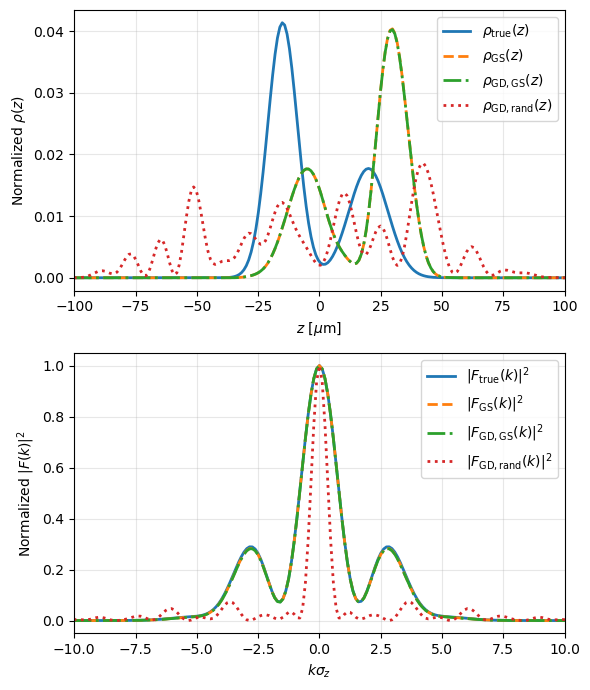

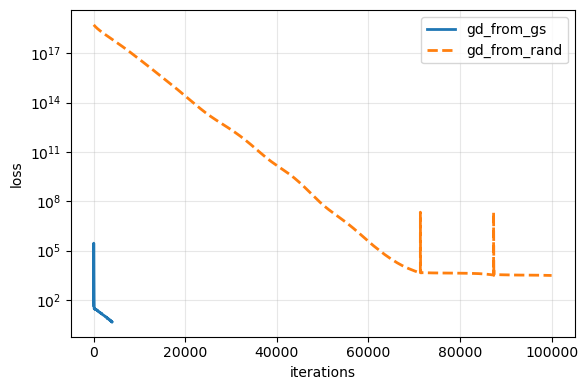

In [6]:
results, data, losses_gd_from_gs, losses_gd_from_rand = demo_compare_methods(device=device)
plot_loss_vs_iterations(losses_gd_from_gs, losses_gd_from_rand, "gd_from_gs", "gd_from_rand")

In [7]:
results

[{'label': 'GS',
  'rho_corr': 0.4718145728111267,
  'spec_loss': 0.9119246006011963,
  'time_sec': 9.49632839486003},
 {'label': 'GD(schroeder) from GS',
  'rho_corr': 0.47286367416381836,
  'spec_loss': 0.6904547810554504,
  'time_sec': 8.413071483373642},
 {'label': 'GD(schroeder) from random',
  'rho_corr': 0.5403246283531189,
  'spec_loss': 4.005094051361084,
  'time_sec': 206.93153872713447}]

In [8]:
benchmark_gs_esults = benchmark_gs_backends(N=1024,
                                            Lz=100e-6,
                                            half_width=50e-6,
                                            n_iters=800,
                                            n_restarts=50,
                                            gamma=100.0,
                                            n_trials=1,
                                           )


[GS-NumPy] best spectral loss over 50 restarts: 1.267e-01
[GS-Torch-cpu] best spectral loss over 50 restarts: 6.660e-02
[GS-Torch-cuda] best spectral loss over 50 restarts: 9.082e-02

% GS timing comparison
\begin{tabular}{llrrrr}
\hline
Backend & Device & Restarts & Time [s] & $\mathrm{corr}(\rho_\mathrm{true},\rho)$ & Spectral log-MSE\\
\hline
numpy & cpu &  50 &   5.875 &  0.329 & 4.26e+00\\
torch & cpu &  50 &   8.410 & -0.271 & 5.95e-02\\
torch & cuda &  50 &  10.208 &  0.002 & 1.85e-01\\
\hline
\end{tabular}
